
# CPython, Python e sua aplicação de alto desempenho
**Python Brasil 2025 — Esbel Tomas Valero Orellana**

> Este notebook acompanha a palestra e contém o conteúdo dos slides com exemplos executáveis.
>
> **Objetivo**: mostrar como combinar Python com C/C++ (via CPython) e explorar paralelismo (OpenMP / CUDA) para acelerar aplicações, usando o problema de multiplicação de matrizes como estudo de caso.

## Sumário 
1. [Preparação do ambiente](#prep)
2. [Baseline 1: Python puro (loops)](#py-puro)
3. [Baseline 2: NumPy (BLAS/LAPACK)](#numpy)
4. [Comparativos de desempenho (gráfico)](#comparativo)
5. [Extensão nativa com CPython API (C)](#cpython)
6. [OpenMP (CPU)](#openmp)
7. [CUDA / GPU (opcional)](#cuda)
8. [Discussão e próximos passos](#fim)

> **Aviso**: alguns experimentos podem levar tempo, dependendo do tamanho da matriz. Use o modo *rápido* para testes durante a apresentação.



<a id="prep"></a>

## 1) Preparação do ambiente

- Este notebook usa apenas **NumPy** e **Matplotlib** (e, opcionalmente, **CuPy** se houver GPU).
- Para a parte de CPython (C), geramos arquivos `mymatmul.c` e `setup.py` e compilamos localmente.
- Ajuste o modo **QUICK** para reduzir o tempo dos testes.


In [1]:

# Configurações gerais
import sys, platform, time, math, statistics as stats
import numpy as np
from random import random   


try:
    import matplotlib.pyplot as plt
except Exception as e:
    raise SystemExit("Matplotlib é necessário para os gráficos. Instale e reexecute.")

# Reprodutibilidade
np.random.seed(42)

# Modo rápido (True: matrizes menores; False: matrizes maiores)
QUICK = True

# Tamanhos padrão (ajuste ao seu hardware)
SIZES = [64, 128, 256] if QUICK else [128, 256, 512, 1024]
REPEATS = 3 if QUICK else 5

print(f"Python {sys.version.split()[0]} | NumPy {np.__version__}")
print(f"Plataforma: {platform.platform()}")
print("Modo QUICK:", QUICK)
print("Tamanhos:", SIZES, "| Repetições por ponto:", REPEATS)


Python 3.11.14 | NumPy 2.3.4
Plataforma: Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39
Modo QUICK: True
Tamanhos: [64, 128, 256] | Repetições por ponto: 3



<a id="py-puro"></a>

## 2) Baseline 1 — Multiplicação de matrizes em **Python puro**

Propósito: visualizar o custo de loops aninhados em Python (sob o CPython e o GIL).
**Atenção**: para tamanhos grandes, este método é muito lento — mantenha tamanhos pequenos no modo *rápido*.


In [2]:
def matmul_py(A, B):
    """
    Multiplicação de matrizes (listas de listas) 3 loops em Python puro.
    A e B devem ser listas de listas de float (ou ints).
    """
    m = len(A)
    n = len(B[0])
    p = len(B)
    p_ = len(A[0])
    assert p == p_, "Dimensões inválidas para multiplicação de matrizes."
    C = [[0.0]*n for _ in range(m)]
    for i in range(m):
        for j in range(n):
            for k in range(p):
                C[i][j] += A[i][k] * B[k][j]
    return C

# Teste pequeno para validar a função

n = 64
A_small = [[random() for i in range(n)] for j in range(n)]
B_small = [[random() for i in range(n)] for j in range(n)]
C_small = matmul_py(A_small, B_small)
print(f"OK: C_small shape = {len(C_small)}x{len(C_small[0])}")

OK: C_small shape = 64x64


In [3]:
def matmul_py_array(A: np.ndarray, B: np.ndarray) -> np.ndarray:
    """
    Multiplicação de matrizes usando loops Python puros e arrays NumPy.
    A e B devem ser np.ndarray 2D.
    """
    m, p_ = A.shape
    p, n = B.shape
    assert p_ == p, "Dimensões inválidas para multiplicação de matrizes."
    C = np.zeros((m, n))

    for i in range(m):
        for j in range(n):
            for k in range(p):
                C[i, j] += A[i, k] * B[k, j]
    return C

# Teste pequeno para validar a função
C_small_array = matmul_py_array(np.array(A_small), np.array(B_small))
print(f"OK: C_small_array shape = {C_small_array.shape}")

OK: C_small_array shape = (64, 64)


In [4]:

# Benchmark rápido Python puro vs NumPy (pequenos)
n = 64 if QUICK else 128
A = np.random.rand(n, n)
B = np.random.rand(n, n)

t0 = time.time()
_ = matmul_py(A.tolist(), B.tolist())
t_py = time.time() - t0

t0 = time.time()
_ = matmul_py_array(A, B)
t_py_array = time.time() - t0

t0 = time.time()
_ = A @ B
t_np = time.time() - t0

print(f"Tamanho {n}x{n} | Python puro: {t_py:.3f}s | NumPy: {t_np:.3f}s | Razão (py/np): {t_py/t_np:.1f}×")
print(f"Tamanho {n}x{n} | Python puro com np.ndarray: {t_py_array:.3f}s | NumPy: {t_np:.3f}s | Razão (py_array/np): {t_py_array/t_np:.1f}×")

Tamanho 64x64 | Python puro: 0.023s | NumPy: 0.001s | Razão (py/np): 28.0×
Tamanho 64x64 | Python puro com np.ndarray: 0.105s | NumPy: 0.001s | Razão (py_array/np): 126.4×


In [5]:
%timeit -n 3 matmul_py(A.tolist(), B.tolist())

31 ms ± 5.05 ms per loop (mean ± std. dev. of 7 runs, 3 loops each)


In [6]:
%timeit -n 3 matmul_py_array(A, B)

148 ms ± 5.86 ms per loop (mean ± std. dev. of 7 runs, 3 loops each)


In [7]:
%timeit -n 3 A @ B

The slowest run took 16.62 times longer than the fastest. This could mean that an intermediate result is being cached.
104 μs ± 138 μs per loop (mean ± std. dev. of 7 runs, 3 loops each)



<a id="numpy"></a>

## 3) Baseline 2 — **NumPy** (BLAS/LAPACK por baixo dos panos)

- `A @ B` chama rotinas otimizadas em C/Fortran (BLAS).
- Para muitos casos, **isso já basta** e é a melhor relação esforço/ganho.


In [8]:
def bench_numpy(sizes=SIZES, repeats=REPEATS, dtype=np.float64):
    results = []
    for n in sizes:
        times = []
        for _ in range(repeats):
            A = np.random.rand(n, n).astype(dtype, copy=False)
            B = np.random.rand(n, n).astype(dtype, copy=False)
            t0 = time.time()
            C = A @ B
            times.append(time.time() - t0)
        results.append({"n": n, "mean": float(np.mean(times)), "std": float(np.std(times)), "dtype": str(dtype)})
    return results

numpy_results = bench_numpy()
numpy_results

[{'n': 64,
  'mean': 6.18298848470052e-05,
  'std': 4.644629450506354e-05,
  'dtype': "<class 'numpy.float64'>"},
 {'n': 128,
  'mean': 0.008302052815755209,
  'std': 0.011153957642327546,
  'dtype': "<class 'numpy.float64'>"},
 {'n': 256,
  'mean': 0.027113040288289387,
  'std': 0.019610784953812584,
  'dtype': "<class 'numpy.float64'>"}]


<a id="comparativo"></a>

## 4) Comparativo de desempenho (gráfico)

- Gráfico do tempo (s) em função do tamanho da matriz `n`.
- Inclui Python puro **apenas para um tamanho de referência**.


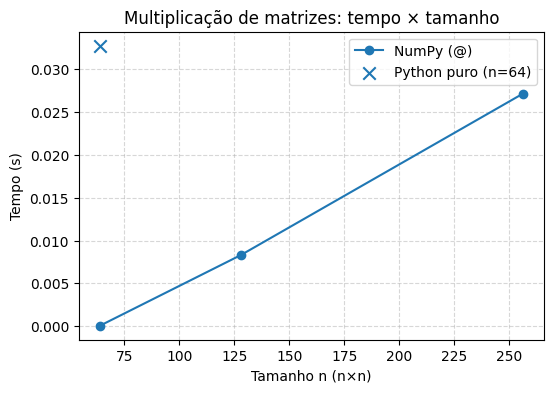

In [9]:

# Coletar um ponto de Python puro para o menor n
n_ref = SIZES[0]
A = np.random.rand(n_ref, n_ref)
B = np.random.rand(n_ref, n_ref)
t0 = time.time()
_ = matmul_py(A.tolist(), B.tolist())
py_point = (n_ref, time.time() - t0)

# Preparar dados NumPy
xs = [r["n"] for r in numpy_results]
ys = [r["mean"] for r in numpy_results]

# Plot (uma figura, sem cores específicas)
plt.figure(figsize=(6,4))
plt.plot(xs, ys, marker="o", label="NumPy (@)")
plt.scatter([py_point[0]], [py_point[1]], marker="x", s=80, label=f"Python puro (n={n_ref})")
plt.xlabel("Tamanho n (n×n)")
plt.ylabel("Tempo (s)")
plt.title("Multiplicação de matrizes: tempo × tamanho")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.show()



<a id="cpython"></a>

## 5) Extensão nativa com **CPython API (C)**

Nesta seção, criamos um módulo C chamado `mymatmul` que expõe `matmul_seq(A, B)` e `matmul_omp(A, B)`:
- Recebe **arrays NumPy** (contíguos, `float64`).
- Usa a C-API do NumPy para acessar memória bruta.
- Implementa multiplicação em C com laços otimizados e, opcionalmente, **OpenMP**.

> Compilar extensões nativas depende do seu ambiente (compilador, flags, etc.).


In [10]:

# Gerar mymatmul.c
mymatmul_c = r'''
#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION
#include <Python.h>
#include <numpy/arrayobject.h>

#ifdef _OPENMP
#include <omp.h>
#endif

static PyObject* matmul_seq(PyObject* self, PyObject* args) {
    PyObject *Aobj, *Bobj;
    if (!PyArg_ParseTuple(args, "OO", &Aobj, &Bobj)) {
        return NULL;
    }

    PyArrayObject *A = (PyArrayObject*) PyArray_FROM_OTF(Aobj, NPY_DOUBLE, NPY_ARRAY_IN_ARRAY);
    PyArrayObject *B = (PyArrayObject*) PyArray_FROM_OTF(Bobj, NPY_DOUBLE, NPY_ARRAY_IN_ARRAY);
    if (!A || !B) {
        Py_XDECREF(A); Py_XDECREF(B);
        PyErr_SetString(PyExc_TypeError, "Falha ao converter inputs para NumPy arrays (float64 contíguos).");
        return NULL;
    }

    if (PyArray_NDIM(A) != 2 || PyArray_NDIM(B) != 2) {
        Py_DECREF(A); Py_DECREF(B);
        PyErr_SetString(PyExc_ValueError, "A e B devem ser matrizes 2D.");
        return NULL;
    }

    npy_intp n = PyArray_DIM(A, 0);
    npy_intp p = PyArray_DIM(A, 1);
    npy_intp p2 = PyArray_DIM(B, 0);
    npy_intp m = PyArray_DIM(B, 1);
    if (p != p2) {
        Py_DECREF(A); Py_DECREF(B);
        PyErr_SetString(PyExc_ValueError, "Dimensões incompatíveis: A(n×p) e B(p×m).");
        return NULL;
    }

    npy_intp dims[2] = {n, m};
    PyArrayObject *C = (PyArrayObject*) PyArray_ZEROS(2, dims, NPY_DOUBLE, 0);
    if (!C) {
        Py_DECREF(A); Py_DECREF(B);
        PyErr_NoMemory();
        return NULL;
    }

    double *a = (double*) PyArray_DATA(A);
    double *b = (double*) PyArray_DATA(B);
    double *c = (double*) PyArray_DATA(C);

    npy_intp lda = PyArray_STRIDES(A)[0] / sizeof(double);
    npy_intp ldb = PyArray_STRIDES(B)[0] / sizeof(double);
    npy_intp ldc = PyArray_STRIDES(C)[0] / sizeof(double);

    for (npy_intp i = 0; i < n; ++i) {
        for (npy_intp k = 0; k < p; ++k) {
            double aik = a[i*lda + k];
            const double* bk = b + k*ldb;
            double* ci = c + i*ldc;
            for (npy_intp j = 0; j < m; ++j) {
                ci[j] += aik * bk[j];
            }
        }
    }

    Py_DECREF(A); Py_DECREF(B);
    return (PyObject*) C;
}


// C = A @ B, A (n x p), B (p x m), double (contíguo)
static PyObject* matmul_omp(PyObject* self, PyObject* args) {
    PyObject *Aobj, *Bobj;
    if (!PyArg_ParseTuple(args, "OO", &Aobj, &Bobj)) {
        return NULL;
    }

    PyArrayObject *A = (PyArrayObject*) PyArray_FROM_OTF(Aobj, NPY_DOUBLE, NPY_ARRAY_IN_ARRAY);
    PyArrayObject *B = (PyArrayObject*) PyArray_FROM_OTF(Bobj, NPY_DOUBLE, NPY_ARRAY_IN_ARRAY);
    if (!A || !B) {
        Py_XDECREF(A); Py_XDECREF(B);
        PyErr_SetString(PyExc_TypeError, "Falha ao converter inputs para NumPy arrays (float64 contíguos).");
        return NULL;
    }

    if (PyArray_NDIM(A) != 2 || PyArray_NDIM(B) != 2) {
        Py_DECREF(A); Py_DECREF(B);
        PyErr_SetString(PyExc_ValueError, "A e B devem ser matrizes 2D.");
        return NULL;
    }

    npy_intp n = PyArray_DIM(A, 0);
    npy_intp p = PyArray_DIM(A, 1);
    npy_intp p2 = PyArray_DIM(B, 0);
    npy_intp m = PyArray_DIM(B, 1);
    if (p != p2) {
        Py_DECREF(A); Py_DECREF(B);
        PyErr_SetString(PyExc_ValueError, "Dimensões incompatíveis: A(n×p) e B(p×m).");
        return NULL;
    }

    npy_intp dims[2] = {n, m};
    PyArrayObject *C = (PyArrayObject*) PyArray_ZEROS(2, dims, NPY_DOUBLE, 0);
    if (!C) {
        Py_DECREF(A); Py_DECREF(B);
        PyErr_NoMemory();
        return NULL;
    }

    double *a = (double*) PyArray_DATA(A);
    double *b = (double*) PyArray_DATA(B);
    double *c = (double*) PyArray_DATA(C);

    npy_intp lda = PyArray_STRIDES(A)[0] / sizeof(double);
    npy_intp ldb = PyArray_STRIDES(B)[0] / sizeof(double);
    npy_intp ldc = PyArray_STRIDES(C)[0] / sizeof(double);

    #pragma omp parallel for if(n*m > 16384) schedule(static)
    for (npy_intp i = 0; i < n; ++i) {
        for (npy_intp k = 0; k < p; ++k) {
            double aik = a[i*lda + k];
            const double* bk = b + k*ldb;
            double* ci = c + i*ldc;
            for (npy_intp j = 0; j < m; ++j) {
                ci[j] += aik * bk[j];
            }
        }
    }

    Py_DECREF(A); Py_DECREF(B);
    return (PyObject*) C;
}

static PyMethodDef Methods[] = {
    {"matmul_omp", matmul_omp, METH_VARARGS, "C = A @ B (double), com OpenMP opcional."},
    {"matmul_seq", matmul_seq, METH_VARARGS, "C = A @ B (double)."},
    {NULL, NULL, 0, NULL}
};

static struct PyModuleDef moduledef = {
    PyModuleDef_HEAD_INIT,
    "mymatmul",
    "Módulo de multiplicação de matrizes em C com OpenMP opcional.",
    -1,
    Methods
};

PyMODINIT_FUNC PyInit_mymatmul(void) {
    import_array();
    return PyModule_Create(&moduledef);
}
'''
open("mymatmul.c", "w", encoding="utf-8").write(mymatmul_c)
print("Arquivo gerado: mymatmul.c")


Arquivo gerado: mymatmul.c


In [11]:

# Gerar setup.py
setup_py = r'''
from setuptools import setup, Extension
import sys
import numpy

extra_compile_args = ['-O3']
extra_link_args = []

if sys.platform.startswith('linux') or sys.platform == 'darwin':
    extra_compile_args += ['-fopenmp']
    extra_link_args += ['-fopenmp']

ext = Extension(
    name='mymatmul',
    sources=['mymatmul.c'],
    include_dirs=[numpy.get_include()],
    extra_compile_args=extra_compile_args,
    extra_link_args=extra_link_args,
)

setup(
    name='mymatmul',
    version='0.1.0',
    description='Multiplicação de matrizes em C com OpenMP opcional (CPython API).',
    ext_modules=[ext],
)
'''
open("setup.py", "w", encoding="utf-8").write(setup_py)
print("Arquivo gerado: setup.py")


Arquivo gerado: setup.py



### Compilação

> Execute **localmente** (pode não funcionar em todos os ambientes online):

```bash
python setup.py build_ext --inplace
```

Se tudo der certo, você verá `mymatmul.*.so` (Linux/Mac) ou `.pyd` (Windows).


In [12]:

# Teste de importação (funciona somente após compilar)
try:
    import mymatmul
    print("mymatmul importado com sucesso.")
except Exception as e:
    print("mymatmul ainda não está compilado/importável:", e)


mymatmul importado com sucesso.


In [22]:

# Benchmark opcional usando a extensão C (se disponível)
def bench_extension(sizes, repeats):
    import mymatmul
    res = []
    for n in sizes:
        times = []
        for _ in range(repeats):
            A = np.random.rand(n, n).astype(np.float64, copy=False)
            B = np.random.rand(n, n).astype(np.float64, copy=False)
            t0 = time.time()
            C = mymatmul.matmul_seq(A, B)
            times.append(time.time() - t0)
        res.append({"n": n, "mean": float(np.mean(times)), "std": float(np.std(times))})
    return res

ext_results = None
try:
    import mymatmul  # noqa
    ext_results = bench_extension(SIZES, REPEATS)
    ext_results
except Exception as e:
    print("Extensão não disponível; pule esta etapa. Motivo:", e)


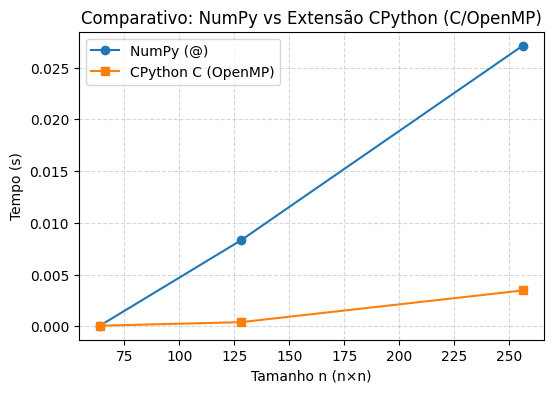

In [23]:

# Plot comparativo: NumPy vs Extensão C (se existir)
if 'ext_results' in globals() and ext_results:
    xs_np = [r["n"] for r in numpy_results]
    ys_np = [r["mean"] for r in numpy_results]
    xs_ex = [r["n"] for r in ext_results]
    ys_ex = [r["mean"] for r in ext_results]

    plt.figure(figsize=(6,4))
    plt.plot(xs_np, ys_np, marker="o", label="NumPy (@)")
    plt.plot(xs_ex, ys_ex, marker="s", label="CPython C (OpenMP)")
    plt.xlabel("Tamanho n (n×n)")
    plt.ylabel("Tempo (s)")
    plt.title("Comparativo: NumPy vs Extensão CPython (C/OpenMP)")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend()
    plt.show()
else:
    print("Sem extensão compilada — gráfico comparativo omitido.")



<a id="openmp"></a>

## 6) Nota sobre **OpenMP (CPU)**

- O código C usa `#pragma omp parallel for` (condicional com `_OPENMP`).
- As flags `-fopenmp` (GCC/Clang) habilitam a paralelização.
- Ajuste `OMP_NUM_THREADS` para controlar o número de threads.

Exemplo:
```bash
export OMP_NUM_THREADS=4
python -c "import numpy as np, mymatmul as mm; A=np.random.rand(512,512); B=np.random.rand(512,512); mm.matmul_omp(A,B)"
```


<a id="openmctypep"></a>

## 7) Integração Python–C com `ctypes`

- `ctypes` permite **reusar bibliotecas C** já existentes — **sem** escrever um módulo CPython completo.

In [47]:
%%writefile matmul.c
#include <stdio.h>
#include <stdlib.h>
#include <omp.h>

// C = A(n x m) = A(n x p) * B(p x m)
void matmul(double *A, double *B, double *C, int n, int m, int p) {
    #pragma omp parallel for 
    for (int i = 0; i < n; i++) {
        for (int j = 0; j < m; j++) {
            double s = 0.0;
            for (int k = 0; k < p; k++) {
                s += A[i*p + k] * B[k*m + j];
            }
            C[i*m + j] = s;
        }
    }
}

Overwriting matmul.c


### 7.1) Compilação da biblioteca compartilhada (`.so`)

No Linux/macOS (ou WSL), compile com:


In [48]:
# Se gcc estiver disponível neste ambiente, o comando abaixo compila a biblioteca.
# Caso contrário, execute localmente: gcc -O3 -fPIC -shared -o libmatmul.so matmul.c
import shutil, subprocess, sys, os
from pathlib import Path

src = Path("matmul.c")
out = Path("libmatmul.so")
if shutil.which("gcc"):
    try:
        subprocess.check_call(["gcc", "-O3", "-fPIC", "-shared", "-o", str(out), str(src), "-fopenmp"])
        print("OK: libmatmul.so gerada.")
    except subprocess.CalledProcessError as e:
        print("Falha ao compilar com gcc:", e)
else:
    print("gcc não encontrado neste ambiente. Compile localmente:")
    print("gcc -O3 -fPIC -shared -o libmatmul.so matmul.c")

OK: libmatmul.so gerada.



### 7.2) Carregando e chamando a função C no Python (`ctypes`)

Definimos a assinatura da função e criamos um *wrapper* Python que aceita/retorna `numpy.ndarray`.

In [49]:

import numpy as np
from ctypes import CDLL, POINTER, c_double, c_int
from pathlib import Path

def load_lib(path="./libmatmul.so"):
    p = Path(path)
    if not p.exists():
        raise FileNotFoundError(f"Biblioteca não encontrada: {p}. Compile com gcc - ver célula anterior.")
    return CDLL(path)

def matmul_ctypes(A: np.ndarray, B: np.ndarray, lib=None):
    if lib is None:
        lib = load_lib()
    n, p = A.shape
    p2, m = B.shape
    if p != p2:
        raise ValueError("Dimensões incompatíveis: A(n x p) e B(p x m).")
    A_c = np.ascontiguousarray(A, dtype=np.float64)
    B_c = np.ascontiguousarray(B, dtype=np.float64)
    C = np.empty((n, m), dtype=np.float64, order="C")
    lib.matmul.argtypes = [POINTER(c_double), POINTER(c_double), POINTER(c_double), c_int, c_int, c_int]
    lib.matmul.restype = None
    lib.matmul(A_c.ctypes.data_as(POINTER(c_double)),
               B_c.ctypes.data_as(POINTER(c_double)),
               C.ctypes.data_as(POINTER(c_double)),
               c_int(n), c_int(m), c_int(p))
    return C


### 7.3) Validação numérica (comparação com NumPy)


In [50]:
A = np.random.rand(64, 64)
B = np.random.rand(64, 64)
lib = None
try:
    lib = load_lib()
except Exception as e:
    print("Aviso:", e)

if lib:
    C_ctypes = matmul_ctypes(A, B, lib=lib)
    C_np = A @ B
    print("Diferença máxima:", np.max(np.abs(C_ctypes - C_np)))
else:
    print("Pule a validação se não compilou a biblioteca ainda.")


Diferença máxima: 1.0658141036401503e-14


In [51]:
def bench(fn, *args, repeats=3):
    ts = []
    for _ in range(repeats):
        t0 = time.time()
        fn(*args)
        ts.append(time.time() - t0)
    return float(np.mean(ts)), float(np.std(ts))

sizes = [128, 256, 512]
if lib:
    for n in sizes:
        A = np.random.rand(n, n)
        B = np.random.rand(n, n)
        t_numpy, _ = bench(lambda X, Y: X @ Y, A, B, repeats=3)
        t_ct, _ = bench(matmul_ctypes, A, B, lib, repeats=3)
        speedup = t_numpy / t_ct if t_ct > 0 else float("inf")
        print(f"n={n:4d} | NumPy: {t_numpy:.4f}s | ctypes: {t_ct:.4f}s | speedup (NumPy/ctypes) = {speedup:.2f}x")
else:
    print("Compile a biblioteca primeiro para executar o benchmark.")


n= 128 | NumPy: 0.0013s | ctypes: 0.0026s | speedup (NumPy/ctypes) = 0.49x
n= 256 | NumPy: 0.0120s | ctypes: 0.0325s | speedup (NumPy/ctypes) = 0.37x
n= 512 | NumPy: 0.0052s | ctypes: 0.7822s | speedup (NumPy/ctypes) = 0.01x



<a id="cuda"></a>

## 8) CUDA / GPU (opcional)

### Opção rápida (sem compilar C/CUDA): **CuPy**
Se você tiver CUDA instalado e uma GPU NVIDIA, a biblioteca **CuPy** replica a API do NumPy e já usa CUDA/CuBLAS.

```python
try:
    import cupy as cp
    n = 1024
    A_gpu = cp.random.rand(n, n, dtype=cp.float64)
    B_gpu = cp.random.rand(n, n, dtype=cp.float64)
    cp.cuda.Stream.null.synchronize()
    t0 = time.time()
    C_gpu = A_gpu @ B_gpu
    cp.cuda.Stream.null.synchronize()
    print("Tempo CuPy:", time.time() - t0)
except Exception as e:
    print("CuPy não disponível:", e)
```

### (Avançado) Kernel CUDA em C
Para quem deseja compilar manualmente um `.cu` e expor via `ctypes`:
1. Escrever um kernel CUDA com `__global__` para `matmul`.
2. Compilar com `nvcc -Xcompiler -fPIC -shared -o libmmcuda.so mm.cu`.
3. Carregar em Python via `ctypes.CDLL("libmmcuda.so")` e escrever *wrappers*.

**Requisitos**:
- CUDA Toolkit (nvcc) instalado e no PATH.
- Driver compatível.
- Linux/WSL: gera `.so`; Windows: pode gerar `.dll` (ajuste o nome do arquivo).


In [36]:
# Execução com fallback automático (sem cuRAND)
# - Tenta cp.random.* (cuRAND)
# - Se falhar, gera no NumPy (CPU) e copia para GPU (cp.asarray)

try:
    import cupy as cp

    # 1) Detecta GPU e inicializa contexto
    if cp.cuda.runtime.getDeviceCount() == 0:
        raise RuntimeError("Nenhuma GPU visível (ative GPU ou verifique o driver/CUDA).")
    cp.cuda.Device(0).use()
    _ = cp.zeros(1)  # força inicialização do contexto
    cp.cuda.Stream.null.synchronize()

    # Tamanho padrão (reaproveita SIZES do notebook, se existir)
    n = (SIZES[-1] if 'SIZES' in globals() and isinstance(SIZES, (list, tuple)) and len(SIZES) > 0 else 1024)

    # 2) Tenta usar cuRAND (cp.random)
    use_fallback = False
    try:
        cp.random.seed(0)
        A_gpu = cp.random.random_sample((n, n), dtype=cp.float64)
        B_gpu = cp.random.random_sample((n, n), dtype=cp.float64)
    except Exception as e_rand:
        print("Falha com cp.random / cuRAND:", e_rand)
        print("→ Usando fallback: gerar no NumPy (CPU) e copiar para GPU.")
        use_fallback = True

    # 3) Fallback: gera dados no CPU e transfere para GPU
    if use_fallback:
        A_cpu = np.random.rand(n, n).astype(np.float64, copy=False)
        B_cpu = np.random.rand(n, n).astype(np.float64, copy=False)
        A_gpu = cp.asarray(A_cpu)
        B_gpu = cp.asarray(B_cpu)

    # 4) GEMM na GPU
    cp.cuda.Stream.null.synchronize()
    t0 = time.time()
    C_gpu = A_gpu @ B_gpu
    cp.cuda.Stream.null.synchronize()
    print(f"Tempo CuPy (n={n}): {time.time() - t0:.4f}s | Fallback usado: {use_fallback}")

except Exception as e:
    print("CuPy/GPU indisponível:", e)


Tempo CuPy (n=256): 0.4690s | Fallback usado: False


In [52]:
%%writefile mm.cu
#include <cuda_runtime.h>
#include <stdio.h>
#include <stdlib.h>

#define CHECK_CUDA(err) do { \
    cudaError_t e = (err); \
    if (e != cudaSuccess) { \
        fprintf(stderr, "CUDA error %s:%d: %s\n", __FILE__, __LINE__, cudaGetErrorString(e)); \
        return; \
    } \
} while (0)

extern "C" __global__
void matmul_kernel(const float* __restrict__ A,
                   const float* __restrict__ B,
                   float* __restrict__ C,
                   int n, int m, int p) {
    // A: (n x p), B: (p x m), C: (n x m) — row-major (C-order)
    int col = blockIdx.x * blockDim.x + threadIdx.x;  // m
    int row = blockIdx.y * blockDim.y + threadIdx.y;  // n
    if (row < n && col < m) {
        float acc = 0.0f;
        for (int k = 0; k < p; ++k) {
            acc += A[row * p + k] * B[k * m + col];
        }
        C[row * m + col] = acc;
    }
}

// Função de alto nível (sem name mangling) chamada via ctypes
extern "C"
void mm_matmul(const float* hA, const float* hB, float* hC, int n, int m, int p) {
    // hA: host A(n x p), hB: host B(p x m), hC: host C(n x m)
    float *dA = nullptr, *dB = nullptr, *dC = nullptr;
    size_t sizeA = (size_t)n * p * sizeof(float);
    size_t sizeB = (size_t)p * m * sizeof(float);
    size_t sizeC = (size_t)n * m * sizeof(float);

    CHECK_CUDA(cudaMalloc((void**)&dA, sizeA));
    CHECK_CUDA(cudaMalloc((void**)&dB, sizeB));
    CHECK_CUDA(cudaMalloc((void**)&dC, sizeC));

    CHECK_CUDA(cudaMemcpy(dA, hA, sizeA, cudaMemcpyHostToDevice));
    CHECK_CUDA(cudaMemcpy(dB, hB, sizeB, cudaMemcpyHostToDevice));

    dim3 block(16, 16);
    dim3 grid((m + block.x - 1) / block.x, (n + block.y - 1) / block.y);
    matmul_kernel<<<grid, block>>>(dA, dB, dC, n, m, p);
    CHECK_CUDA(cudaGetLastError());
    CHECK_CUDA(cudaDeviceSynchronize());

    CHECK_CUDA(cudaMemcpy(hC, dC, sizeC, cudaMemcpyDeviceToHost));

    cudaFree(dA);
    cudaFree(dB);
    cudaFree(dC);
}

Writing mm.cu


In [53]:
import os, sys, subprocess, shlex

cmd = "nvcc -Xcompiler -fPIC -shared -O3 -o libmmcuda.so mm.cu"
print("Compilando:", cmd)
try:
    subprocess.check_call(shlex.split(cmd))
    print("OK: libmmcuda.so gerada.")
except subprocess.CalledProcessError as e:
    print("Falha ao compilar com nvcc:", e)
    print("Verifique se o CUDA Toolkit está instalado e nvcc está no PATH.")

Compilando: nvcc -Xcompiler -fPIC -shared -O3 -o libmmcuda.so mm.cu
OK: libmmcuda.so gerada.


In [54]:
import ctypes as ct
lib = ct.CDLL("./libmmcuda.so")

In [55]:
import numpy as np
import ctypes as ct
from pathlib import Path

# Carrega a biblioteca compartilhada
lib_path = Path("./libmmcuda.so")
if not lib_path.exists():
    raise FileNotFoundError("libmmcuda.so não encontrada. Compile antes com nvcc.")

lib = ct.CDLL("./libmmcuda.so")

# Define assinatura da função C: void mm_matmul(const float*, const float*, float*, int, int, int)
lib.mm_matmul.argtypes = [
    ct.POINTER(ct.c_float),  # A
    ct.POINTER(ct.c_float),  # B
    ct.POINTER(ct.c_float),  # C
    ct.c_int,                # n
    ct.c_int,                # m
    ct.c_int                 # p
]
lib.mm_matmul.restype = None

def mm_matmul(A: np.ndarray, B: np.ndarray) -> np.ndarray:
    """
    Multiplicação de matrizes usando a lib CUDA (float32, C-order).
    A: (n, p), B: (p, m) -> C: (n, m)
    """
    if A.dtype != np.float32 or B.dtype != np.float32:
        raise TypeError("Use float32 em A e B.")
    if not (A.flags.c_contiguous and B.flags.c_contiguous):
        raise ValueError("A e B devem ser C-contiguous.")
    n, p = A.shape
    p2, m = B.shape
    if p != p2:
        raise ValueError("Dimensões incompatíveis: A(n x p) e B(p x m).")

    C = np.empty((n, m), dtype=np.float32, order='C')

    A_ptr = A.ctypes.data_as(ct.POINTER(ct.c_float))
    B_ptr = B.ctypes.data_as(ct.POINTER(ct.c_float))
    C_ptr = C.ctypes.data_as(ct.POINTER(ct.c_float))

    lib.mm_matmul(A_ptr, B_ptr, C_ptr, int(n), int(m), int(p))
    return C


<a id="fim"></a>

## 8) Discussão e próximos passos

- **Quando vale a pena escrever C/C++?** Partes críticas e *hotspots*.
- **NumPy primeiro**: costuma ser suficiente para 80% dos casos.
- **Extensões CPython**: máximo controle e desempenho, com custo de complexidade.
- **GPU**: use **CuPy** para acelerar com baixa fricção; para casos extremos, CUDA C/C++.

### Referências
- Documentação oficial (Extending/Embedding): https://docs.python.org/3/extending/
- NumPy C-API: https://numpy.org/doc/stable/reference/c-api/
- OpenMP: https://www.openmp.org/
- CuPy: https://cupy.dev/
